In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu
import seaborn as sns


In [54]:
data_df = pd.read_excel('diplom.xlsx', sheet_name='Данные')
clients_df = pd.read_excel('diplom.xlsx', sheet_name='Clients')
region_dict_df = pd.read_excel('diplom.xlsx', sheet_name='Region_dict')

# ----------------------------------------------
# table research

In [55]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37989 entries, 0 to 37988
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_order     37989 non-null  int64  
 1   id_client    37401 non-null  float64
 2   amt_payment  35845 non-null  float64
 3   dtime_pay    35828 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.2+ MB


In [56]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55605 entries, 0 to 55604
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55605 non-null  int64         
 1   dtime_ad          55356 non-null  datetime64[ns]
 2   nflag_test        55605 non-null  int64         
 3   id_trading_point  55605 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.7 MB


# ----------------------------------------------
# clearing the data

In [57]:
data_df.dropna(inplace=True)
clients_df.dropna(inplace=True)

In [58]:
data_df['id_client'] = data_df['id_client'].astype(int)

# ----------------------------------------------
# functions for calculation

In [59]:
def test_calc(r1, r2, alpha = 0.05):
    s, p = ttest_ind(r1, r2)

    if p < alpha:
        print("Гипотеза не подтверждается, средние не равны")
        print("Разница средних = ", r1.mean() - r2.mean())
    else:
        print("Гипотеза подтверждается, средние равны")
        print("Разница средних = 0")

    return s, p

In [60]:
def mann_whitney_func(r1, r2, alpha = 0.05):
    s, p = mannwhitneyu(r1, r2)

    if p < alpha:
        print("Распределения не равны")
    else:
        print("Распределения равны")

    return s, p

# ----------------------------------------------
# visual_trading_point

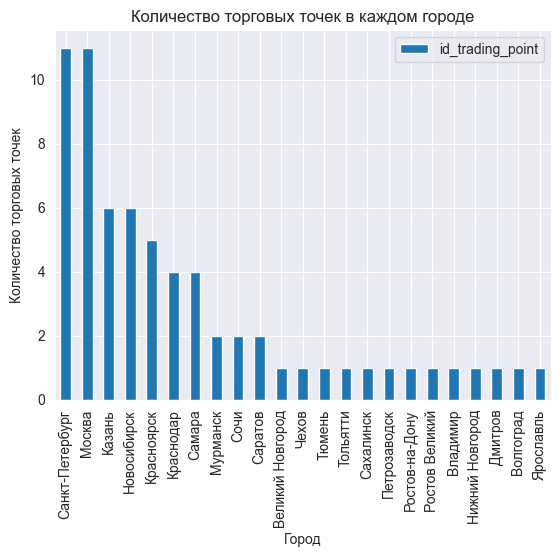

In [61]:
grouped_points = region_dict_df.groupby('city').count()['id_trading_point'].reset_index().sort_values(by = 'id_trading_point',  ascending = False)

grouped_points.plot(x='city', y='id_trading_point', kind='bar')
plt.xlabel('Город')
plt.ylabel('Количество торговых точек')
plt.title('Количество торговых точек в каждом городе')

plt.show()

# ----------------------------------------------
# cleaning incorrectly filled points

In [62]:
merged_df = data_df.merge(clients_df, on='id_client', how='outer')
merged_df = merged_df.merge(region_dict_df, on='id_trading_point')

merged_df['amt_payment'] = merged_df['amt_payment'].fillna(0)

points_df = (
    merged_df.groupby(['id_client', 'id_trading_point', 'city'])
    .agg(id_order=('id_order', 'count'), amt_payment=('amt_payment', 'sum'))
    .reset_index()
    .merge(clients_df[['id_client', 'dtime_ad', 'nflag_test']], on='id_client')
)

print(points_df)

       id_client  id_trading_point             city  id_order  amt_payment  \
0         178561             453.0  Санкт-Петербург         1       3052.0   
1         178562            2652.0           Москва         1       2439.0   
2         178563             112.0  Санкт-Петербург         1        768.0   
3         178564              26.0   Ростов-на-Дону         0          0.0   
4         178565             739.0      Новосибирск         1        958.0   
...          ...               ...              ...       ...          ...   
55351     331949             573.0  Санкт-Петербург         0          0.0   
55352     331950            1654.0           Москва         0          0.0   
55353     331954             544.0           Казань         0          0.0   
55354     331955              72.0             Сочи         0          0.0   
55355     331964             202.0       Красноярск         0          0.0   

                     dtime_ad  nflag_test  
0     2022-06-03 02

In [63]:
zero_group_points = [
    int(i) for i in points_df['id_trading_point'].unique()
    if not any(points_df[(points_df['id_trading_point'] == i) & (points_df['nflag_test'] == 0)]['amt_payment'])
    or not any(points_df[(points_df['id_trading_point'] == i) & (points_df['nflag_test'] == 1)]['amt_payment'])
]

print(zero_group_points)

[26, 739, 866, 46, 1099, 1015, 603, 810, 800, 228, 1, 13, 23, 4, 7]


In [64]:
empty_group_points = [
    int(i) for i in points_df['id_trading_point'].unique()
    if points_df.loc[(points_df['id_trading_point'] == i) & (points_df['nflag_test'] == 0), 'id_client'].empty
    or points_df.loc[(points_df['id_trading_point'] == i) & (points_df['nflag_test'] == 1), 'id_client'].empty
]

print(empty_group_points)

[739, 866, 1099, 1015, 603, 810, 800, 228]


# ----------------------------------------------
# calculating the overall result

In [65]:
df_filtered = points_df[~points_df['id_trading_point'].isin(empty_group_points + zero_group_points)].reset_index()

print(df_filtered)

       index  id_client  id_trading_point             city  id_order  \
0          0     178561             453.0  Санкт-Петербург         1   
1          1     178562            2652.0           Москва         1   
2          2     178563             112.0  Санкт-Петербург         1   
3          6     178567             453.0  Санкт-Петербург         1   
4          7     178568            3786.0           Москва         3   
...      ...        ...               ...              ...       ...   
45313  55351     331949             573.0  Санкт-Петербург         0   
45314  55352     331950            1654.0           Москва         0   
45315  55353     331954             544.0           Казань         0   
45316  55354     331955              72.0             Сочи         0   
45317  55355     331964             202.0       Красноярск         0   

       amt_payment                dtime_ad  nflag_test  
0           3052.0 2022-06-03 02:47:49.183           0  
1           2439.0 20

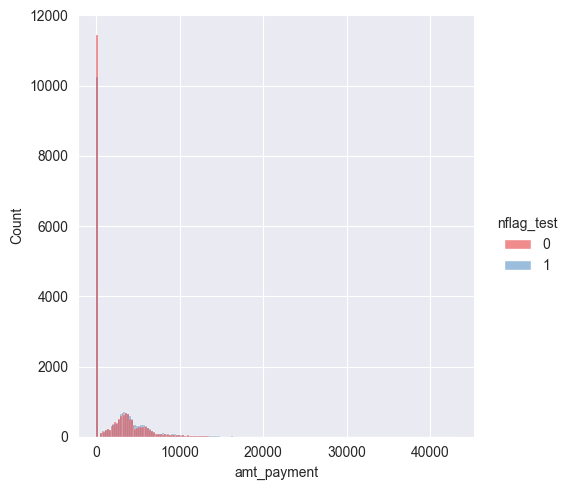

In [66]:
sns.displot(df_filtered, x='amt_payment', hue='nflag_test', palette='Set1')

plt.show()

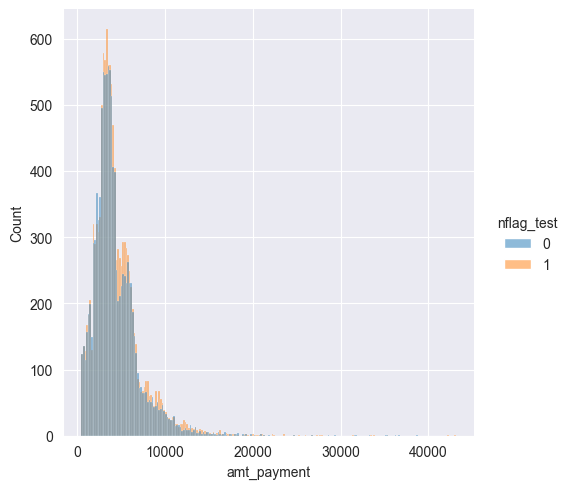

In [67]:
sns.displot(df_filtered[df_filtered['amt_payment'] > 0], x='amt_payment', hue='nflag_test')

plt.show()

In [68]:
print(test_calc(df_filtered[df_filtered['nflag_test'] == 1]['amt_payment'], df_filtered[df_filtered['nflag_test'] == 0]['amt_payment']))

Гипотеза не подтверждается, средние не равны
Разница средних =  263.088912844727
(9.456798235171377, 3.3214645838934018e-21)


In [69]:
print(mann_whitney_func(df_filtered[df_filtered['nflag_test'] == 1]['amt_payment'], df_filtered[df_filtered['nflag_test'] == 0]['amt_payment']))

Распределения не равны
(270040116.0, 3.008345273971902e-24)


# ----------------------------------------------
# segmentation

In [70]:
def perform_ab_analysis(df_filtered, city):
    city_df = df_filtered[df_filtered['city'] == city]

    sns.displot(city_df, x='amt_payment', hue='nflag_test', palette='Set2')
    plt.xlabel('Сумма платежа')
    plt.ylabel('Частота')
    plt.title(f'Распределение платежей в городе {city}')
    plt.show()

    non_zero_payments_df = city_df[city_df['amt_payment'] > 0]

    sns.displot(non_zero_payments_df, x='amt_payment', hue='nflag_test', palette='Set2')
    plt.xlabel('Сумма платежа (ненулевые)')
    plt.ylabel('Частота')
    plt.title(f'Распределение ненулевых платежей в городе {city}')
    plt.show()

    print("t-test абсолютные платежи")
    test_calc(city_df[city_df['nflag_test'] == 1]['amt_payment'], city_df[city_df['nflag_test'] == 0]['amt_payment'])
    print()

    print("t-test конверсия в платеж")
    test_calc(city_df[city_df['nflag_test'] == 1]['amt_payment'].apply(lambda x: 1 if x > 0 else 0), city_df[city_df['nflag_test'] == 0]['amt_payment'].apply(lambda x: 1 if x > 0 else 0))
    print()

    print("Тест Манна-Уитни")
    print(mann_whitney_func(city_df[city_df['nflag_test'] == 1]['amt_payment'], city_df[city_df['nflag_test'] == 0]['amt_payment']))


# ----------------------------------------------
# Moscow

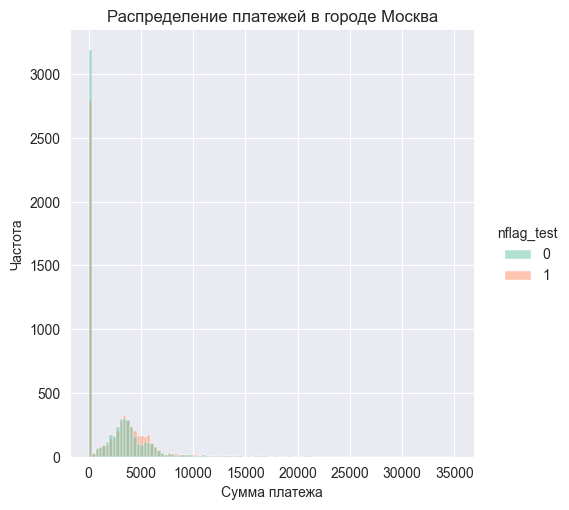

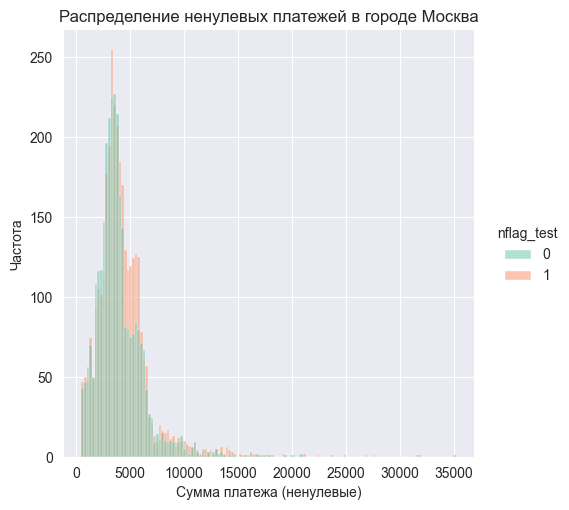

t-test абсолютные платежи
Гипотеза не подтверждается, средние не равны
Разница средних =  381.7784892750842

t-test конверсия в платеж
Гипотеза не подтверждается, средние не равны
Разница средних =  0.05557800593933432

Тест Манна-Уитни
Распределения не равны
(20595574.5, 7.010591402203484e-16)


In [71]:
perform_ab_analysis(df_filtered, 'Москва')

# ----------------------------------------------
# Saint Petersburg

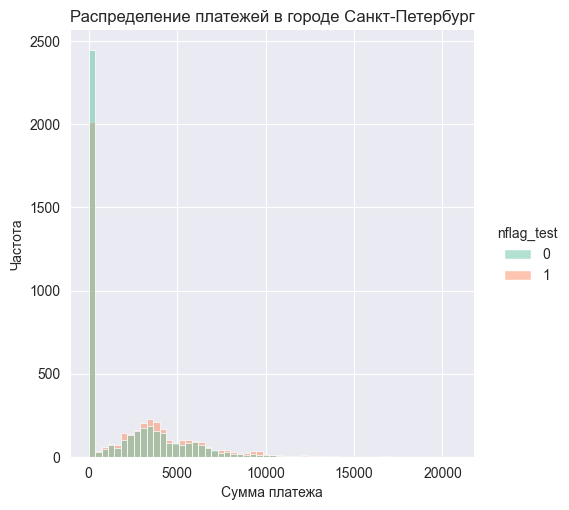

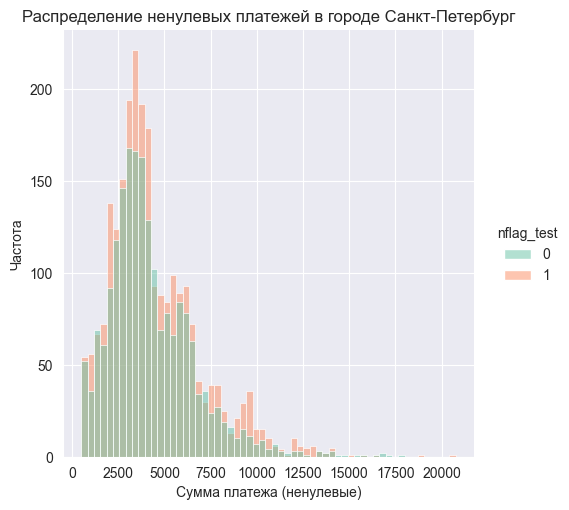

t-test абсолютные платежи
Гипотеза не подтверждается, средние не равны
Разница средних =  513.9039043833998

t-test конверсия в платеж
Гипотеза не подтверждается, средние не равны
Разница средних =  0.09877797751600403

Тест Манна-Уитни
Распределения не равны
(10899685.5, 2.039218421795376e-20)


In [72]:
perform_ab_analysis(df_filtered, 'Санкт-Петербург')

# ----------------------------------------------
# other cities

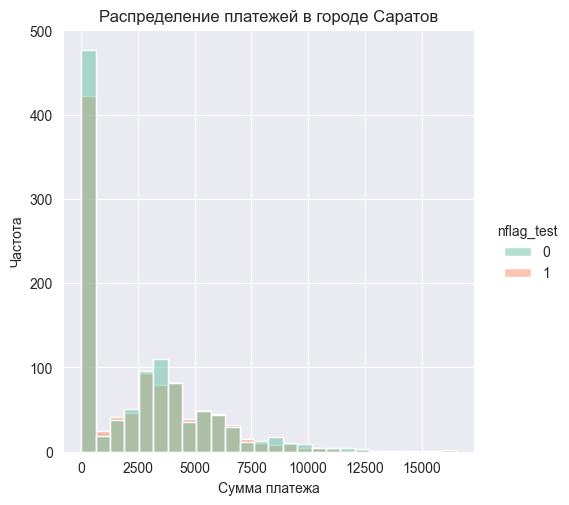

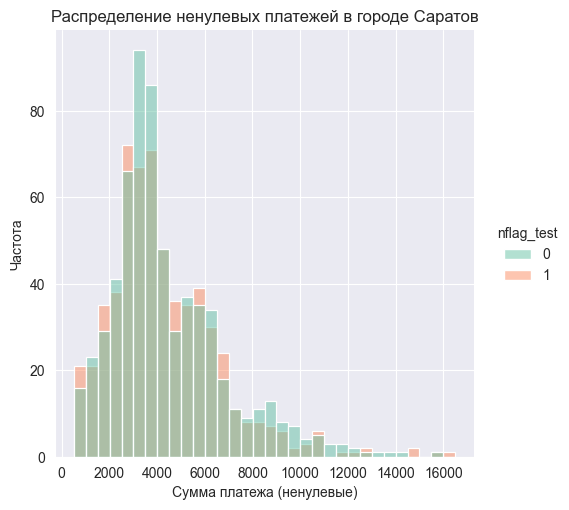

t-test абсолютные платежи
Гипотеза подтверждается, средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза подтверждается, средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения равны
(565440.5, 0.7833257779753139)


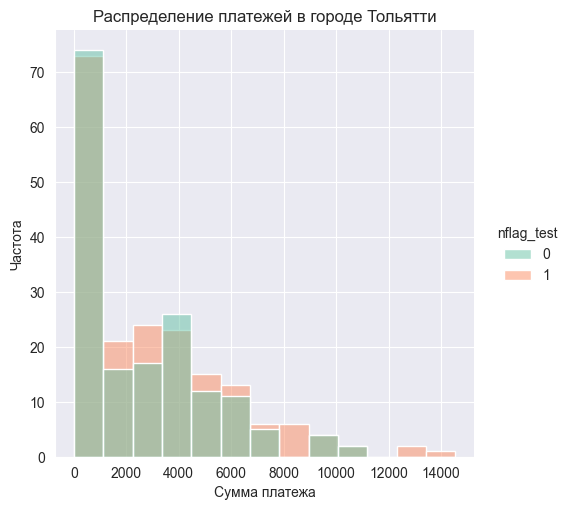

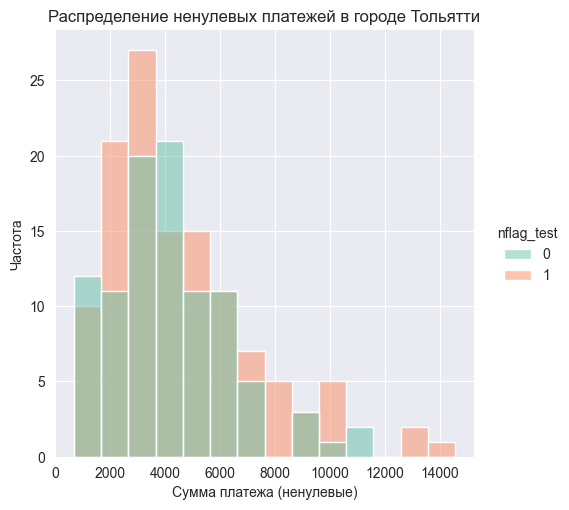

t-test абсолютные платежи
Гипотеза подтверждается, средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза подтверждается, средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения равны
(17020.5, 0.22134177144014489)


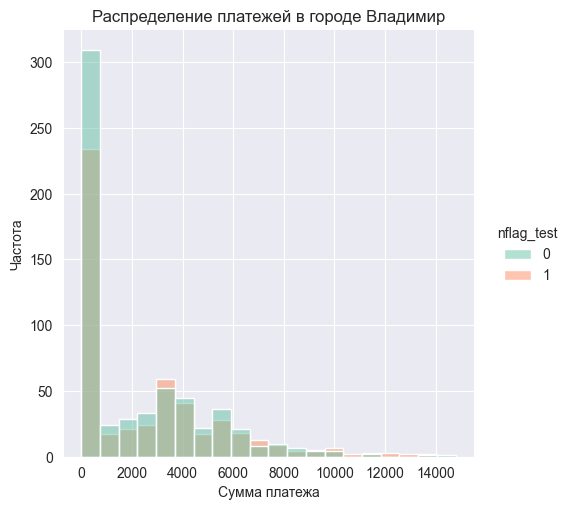

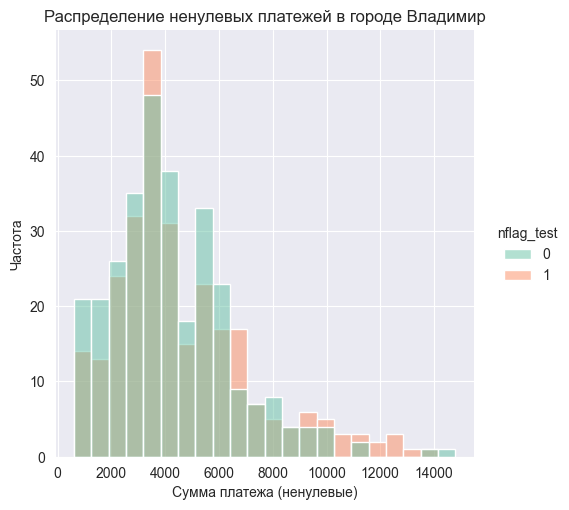

t-test абсолютные платежи
Гипотеза не подтверждается, средние не равны
Разница средних =  438.6098419243094

t-test конверсия в платеж
Гипотеза подтверждается, средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения не равны
(165625.0, 0.03166761411886426)


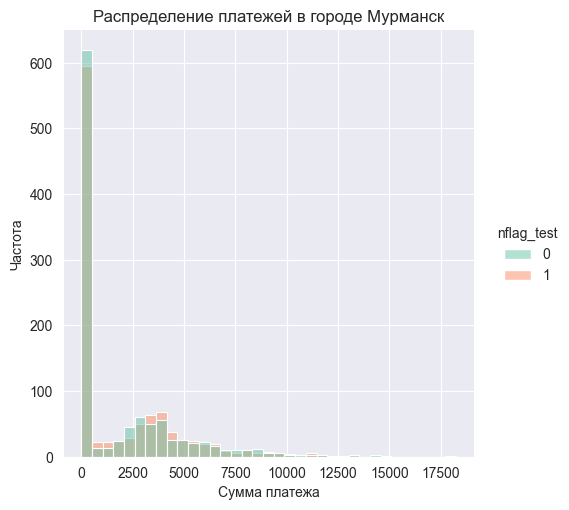

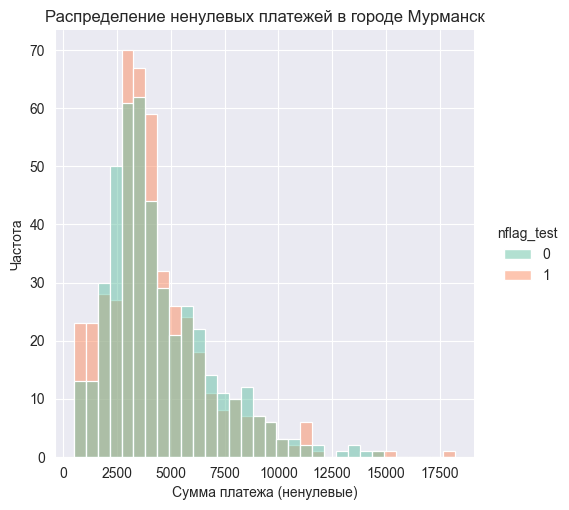

t-test абсолютные платежи
Гипотеза подтверждается, средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза подтверждается, средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения равны
(569507.5, 0.5434251528583327)


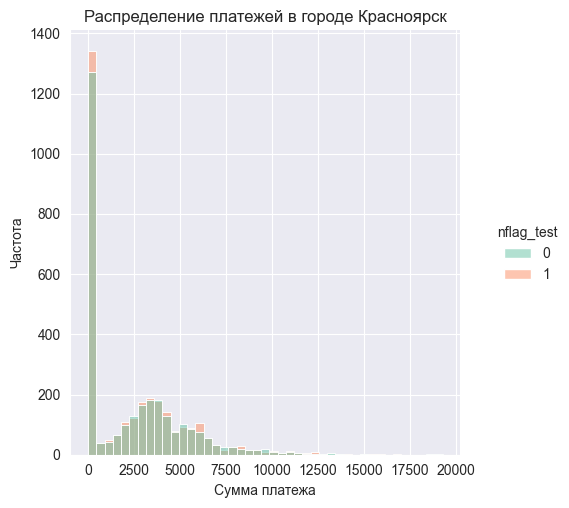

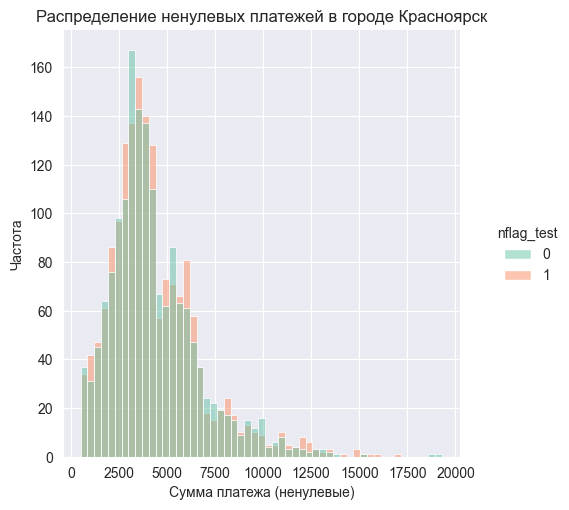

t-test абсолютные платежи
Гипотеза подтверждается, средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза подтверждается, средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения равны
(4393882.0, 0.8770469886251647)


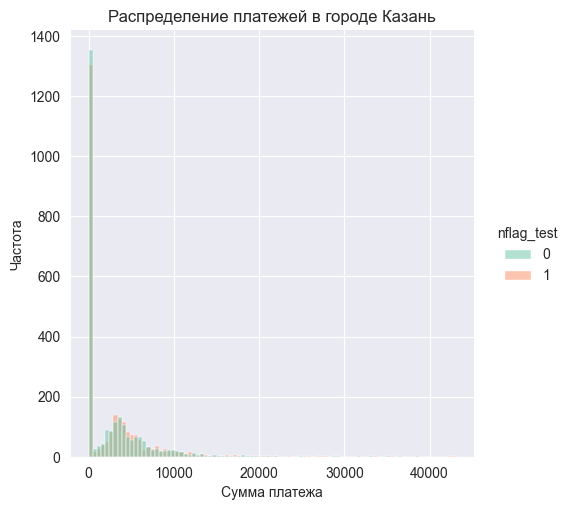

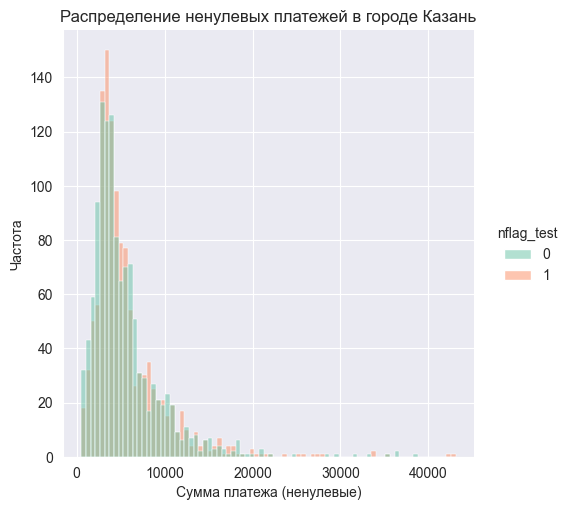

t-test абсолютные платежи
Гипотеза подтверждается, средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза подтверждается, средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения равны
(3263925.0, 0.37726004167062477)


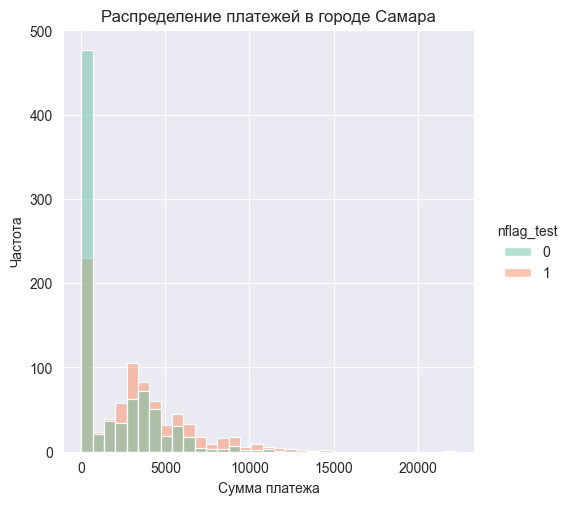

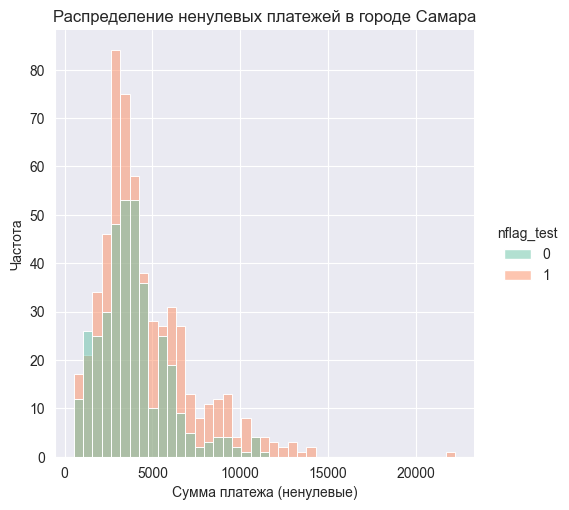

t-test абсолютные платежи
Гипотеза не подтверждается, средние не равны
Разница средних =  1544.3720191247648

t-test конверсия в платеж
Гипотеза не подтверждается, средние не равны
Разница средних =  0.2772412939282998

Тест Манна-Уитни
Распределения не равны
(444975.5, 4.3252018677941474e-30)


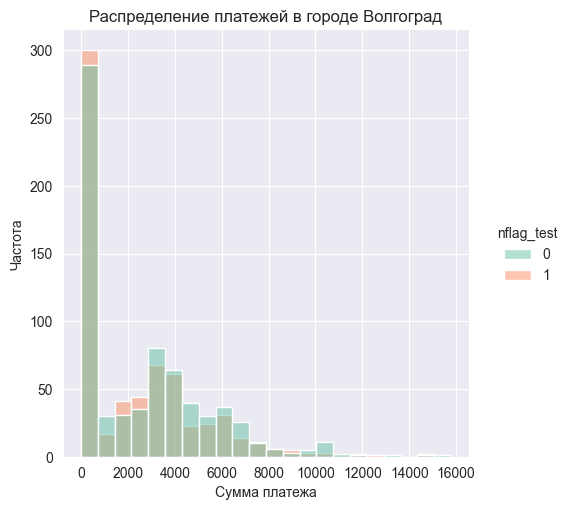

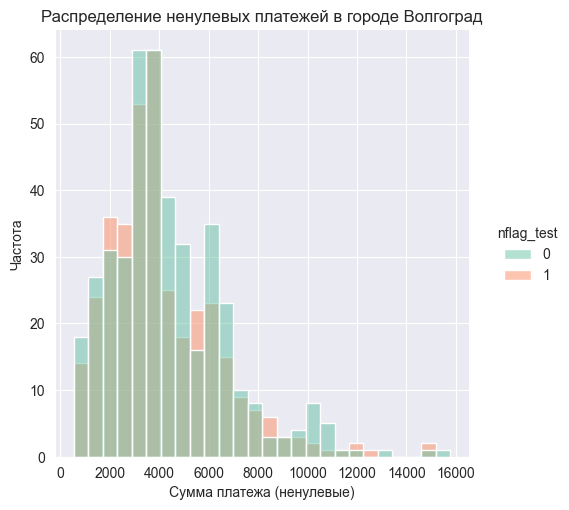

t-test абсолютные платежи
Гипотеза не подтверждается, средние не равны
Разница средних =  -312.89040013337035

t-test конверсия в платеж
Гипотеза подтверждается, средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения не равны
(216128.0, 0.03323940159324538)


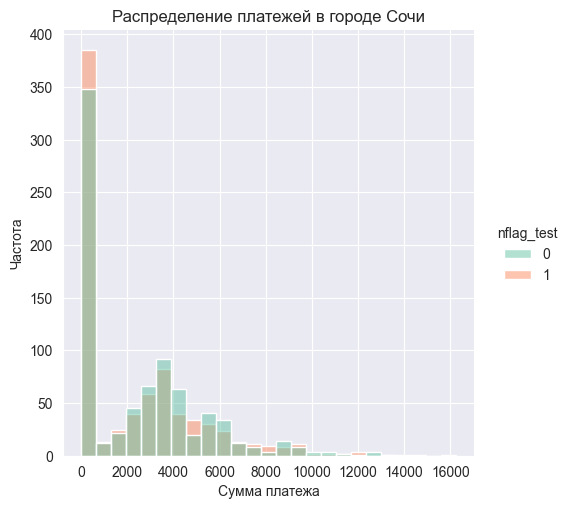

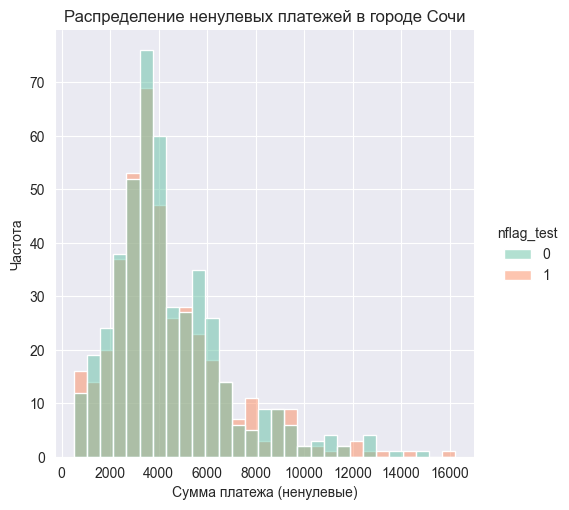

t-test абсолютные платежи
Гипотеза подтверждается, средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза не подтверждается, средние не равны
Разница средних =  -0.04931605920420967

Тест Манна-Уитни
Распределения равны
(303988.5, 0.05698257474271896)


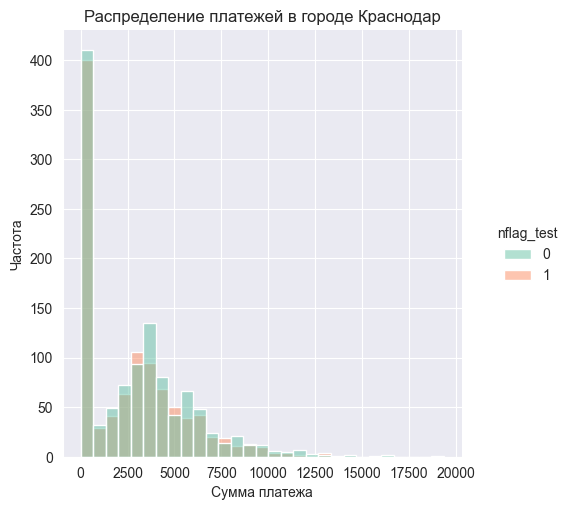

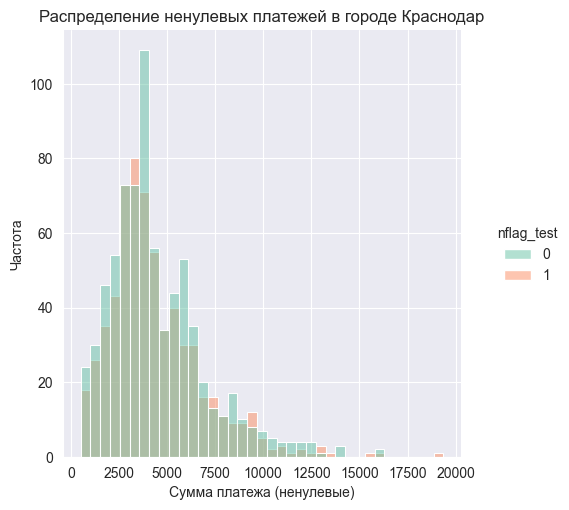

t-test абсолютные платежи
Гипотеза подтверждается, средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза подтверждается, средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения равны
(556499.0, 0.05938101983441801)


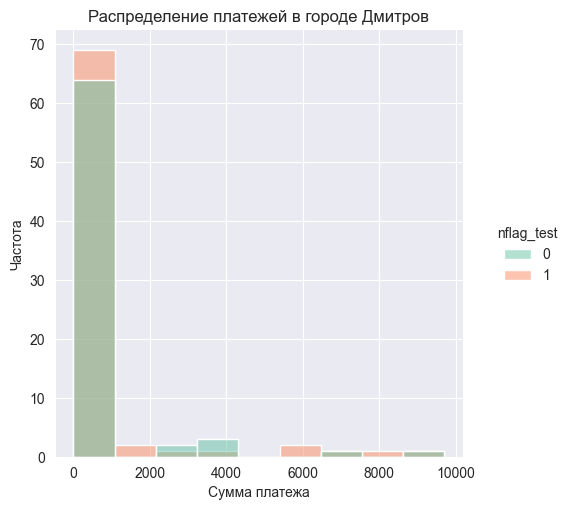

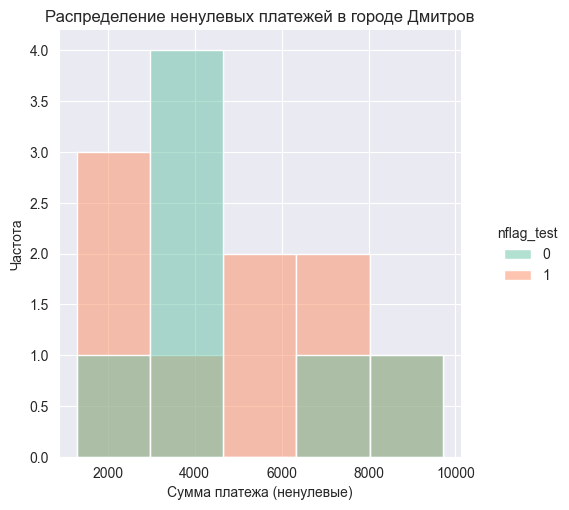

t-test абсолютные платежи
Гипотеза подтверждается, средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза подтверждается, средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения равны
(2816.0, 0.7422551789442879)


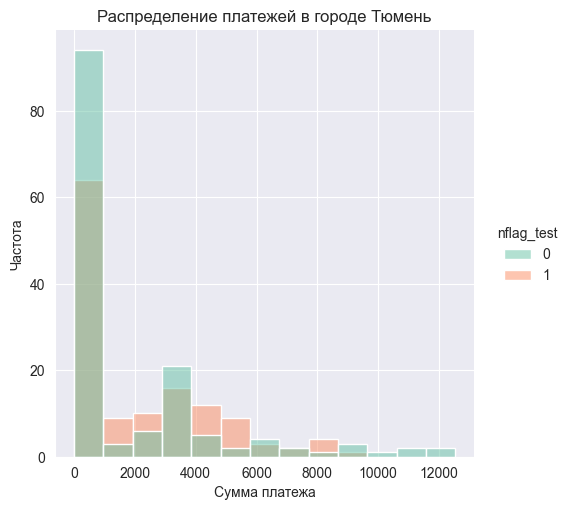

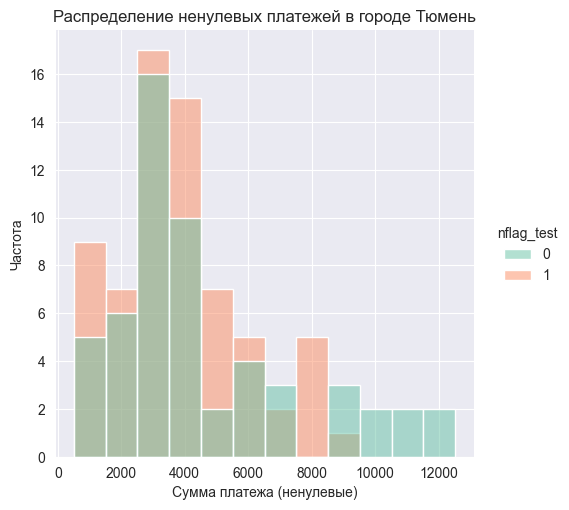

t-test абсолютные платежи
Гипотеза подтверждается, средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза не подтверждается, средние не равны
Разница средних =  0.1463645943097998

Тест Манна-Уитни
Распределения не равны
(10741.0, 0.038066216007540725)


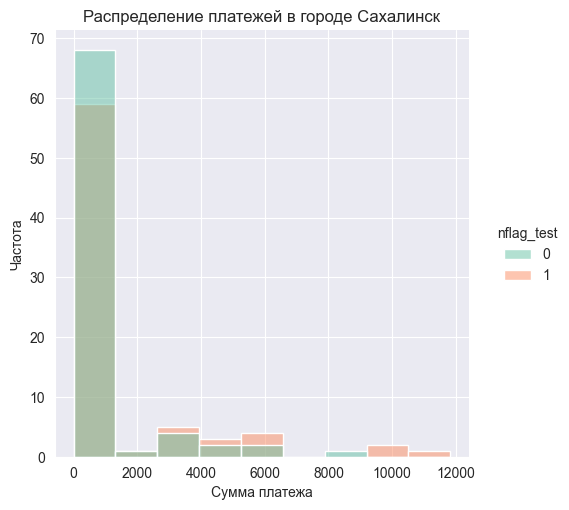

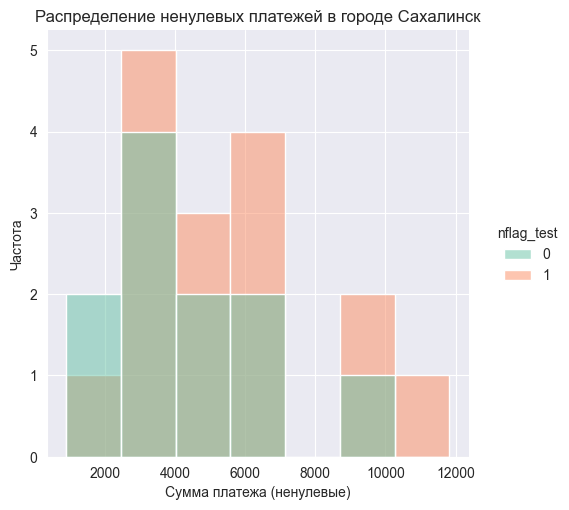

t-test абсолютные платежи
Гипотеза подтверждается, средние равны
Разница средних = 0

t-test конверсия в платеж
Гипотеза подтверждается, средние равны
Разница средних = 0

Тест Манна-Уитни
Распределения равны
(3159.5, 0.19868569514015844)


In [73]:
other_cities = df_filtered['city'].unique()
other_cities = other_cities[(other_cities != 'Москва') & (other_cities != 'Санкт-Петербург')]

for city in other_cities:
    city_df = df_filtered[df_filtered['city'] == city]
    perform_ab_analysis(city_df, city)

# ----------------------------------------------
# report

In [74]:
df_report = []
for city in df_filtered['city'].unique():
    df_loc = df_filtered[df_filtered['city'] == city]
    unique_trading_points = df_loc['id_trading_point'].unique()
    df_loc_grouped = df_loc.groupby('id_trading_point')

    for trading_point in unique_trading_points:
        df_loc_f = df_loc_grouped.get_group(trading_point)

        filter_test = df_loc_f['nflag_test'] == 1
        filter_control = df_loc_f['nflag_test'] == 0

        count_test = df_loc_f[filter_test]['nflag_test'].count()
        count_control = df_loc_f[filter_control]['nflag_test'].count()
        count_all = count_test + count_control

        amt_payment_test = df_loc_f[filter_test]['amt_payment']
        amt_payment_control = df_loc_f[filter_control]['amt_payment']

        sigma_test = amt_payment_test.std()
        sigma_control = amt_payment_control.std()

        avg_test = amt_payment_test.mean()
        avg_control = amt_payment_control.mean()
        diff = avg_test - avg_control

        s_a, p_a = test_calc(amt_payment_test, amt_payment_control)
        s_p, p_p = test_calc(amt_payment_test, amt_payment_control)
        m_s, m_p = mann_whitney_func(amt_payment_test, amt_payment_control)

        result = {
            'city': city,
            'id_trading_point': trading_point,
            'count_test': count_test,
            'count_control': count_control,
            'count_all': count_all,
            'avg_test': avg_test,
            'avg_control': avg_control,
            'sigma_test': sigma_test,
            'sigma_control': sigma_control,
            'diff': diff,
            'abs_ttest_s': s_a,
            'abs_ttest_p': p_a,
            'pr_ttest_p': s_p
        }

        df_report.append(result)

df_result = pd.DataFrame(df_report)

Гипотеза не подтверждается, средние не равны
Разница средних =  612.0424920007797
Гипотеза не подтверждается, средние не равны
Разница средних =  612.0424920007797
Распределения не равны
Гипотеза подтверждается, средние равны
Разница средних = 0
Гипотеза подтверждается, средние равны
Разница средних = 0
Распределения не равны
Гипотеза не подтверждается, средние не равны
Разница средних =  531.6059475298125
Гипотеза не подтверждается, средние не равны
Разница средних =  531.6059475298125
Распределения не равны
Гипотеза подтверждается, средние равны
Разница средних = 0
Гипотеза подтверждается, средние равны
Разница средних = 0
Распределения равны
Гипотеза подтверждается, средние равны
Разница средних = 0
Гипотеза подтверждается, средние равны
Разница средних = 0
Распределения равны
Гипотеза не подтверждается, средние не равны
Разница средних =  761.1992559198145
Гипотеза не подтверждается, средние не равны
Разница средних =  761.1992559198145
Распределения не равны
Гипотеза не подтвержда

In [75]:
def get_diff_category(row):
    if row['abs_ttest_p'] < 0.05:
        if row['diff'] > 0:
            return 'Positive'
        elif row['diff'] < 0:
            return 'Negative'
    return 'No diff'

df_result['nflag_diff'] = df_result.apply(get_diff_category, axis=1)
df_result['pecent_count'] = df_result['count_all'] / df_result['count_all'].sum()

In [76]:
with pd.ExcelWriter('repo.xlsx', engine='xlsxwriter') as writer:
    df_result[df_result['nflag_diff'] == 'Positive'].to_excel(writer, sheet_name='Успешные ТТ', index=False)
    df_result[df_result['nflag_diff'] == 'Negative'].to_excel(writer, sheet_name='Неуспешные ТТ', index=False)
    df_result[df_result['nflag_diff'] == 'No diff'].to_excel(writer, sheet_name='Нейтральные ТТ', index=False)